# Amazon Sentiment Analysis

Techniques Used:  
* VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
* Roberta Pretrained Model from huggingface
* Huggingface Pipeline

### Import Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [58]:
plt.style.use('ggplot')
nlp = spacy.load('en_core_web_sm')
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Initialize Dataframe

In [5]:
df = pd.read_csv('/content/Reviews.csv', engine='python')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
df.shape

(84867, 10)

In [8]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               6
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [10]:
df.iloc[0].Text

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### Exploratory Data Analysis

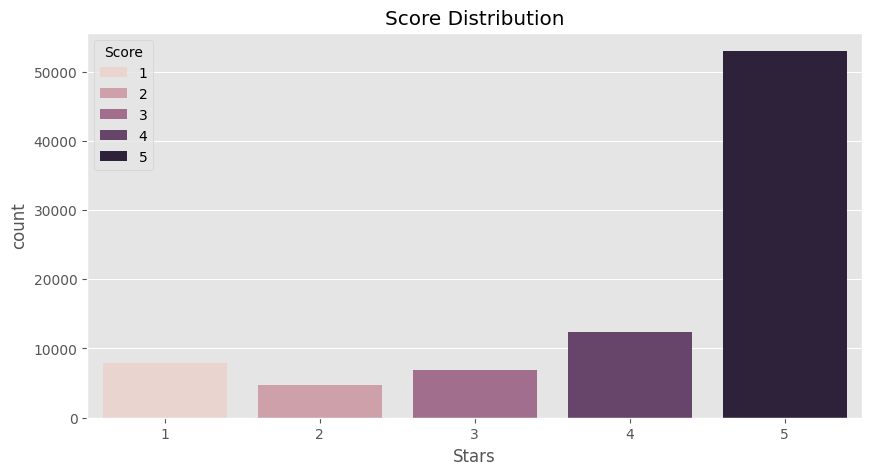

In [17]:
plt.figure(figsize=(10, 5))
plt.title('Score Distribution')
sns.countplot(x='Score', data=df, hue='Score')
plt.xlabel('Stars')
plt.show()

### Basic NLTK & spaCy

In [47]:
example = df['Text'].iloc[50]
doc = nlp(example)
doc

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.

In [48]:
tokens = [token.text for token in doc]
tokens

['This',
 'oatmeal',
 'is',
 'not',
 'good',
 '.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 "n't",
 'like',
 'it',
 '.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [53]:
tags = [(token.text, token.tag_) for token in doc]
tags

[('This', 'DT'),
 ('oatmeal', 'JJ'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'JJ'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ','),
 ('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('like', 'VB'),
 ('it', 'PRP'),
 ('.', '.'),
 ('Quaker', 'NNP'),
 ('Oats', 'NNP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('go', 'VB'),
 ('.', '.')]

### #) VADER Sentiment Scoring

In [59]:
sia = SentimentIntensityAnalyzer()

In [62]:
sia.polarity_scores('I am happy')

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [63]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [64]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [65]:
results = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    id = row['Id']
    results[index] = sia.polarity_scores(text)

  0%|          | 0/84867 [00:00<?, ?it/s]

In [67]:
vader_score_df = pd.DataFrame(results).T
vader_score_df.head()

,neg,neu,pos,compound
0,0.000,0.695,0.305,0.9441
1,0.138,0.862,0.000,-0.5664
2,0.091,0.754,0.155,0.8265
3,0.000,1.000,0.000,0.0000
4,0.000,0.552,0.448,0.9468


In [76]:
vader_score_df = vader_score_df.reset_index().rename(columns={'index': 'Id'})
vader_score_df = vader_score_df.merge(df, how='left')
vader_score_df.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0.000,0.695,0.305,0.9441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.138,0.862,0.000,-0.5664,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,2,0.091,0.754,0.155,0.8265,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,3,0.000,1.000,0.000,0.0000,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
4,4,0.000,0.552,0.448,0.9468,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...


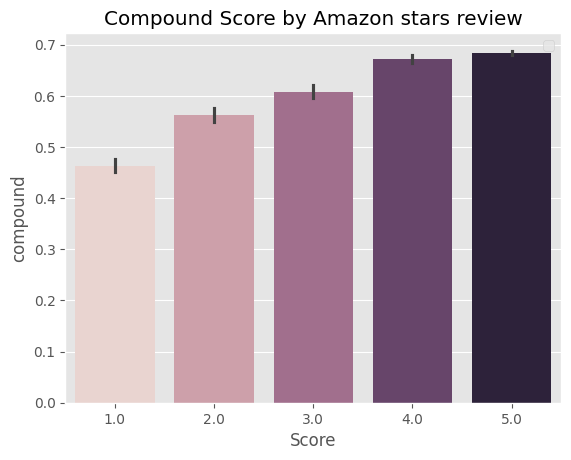

In [81]:
sns.barplot(data=vader_score_df, x='Score', y='compound', hue='Score')
plt.title('Compound Score by Amazon stars review')
plt.legend('')
plt.show()

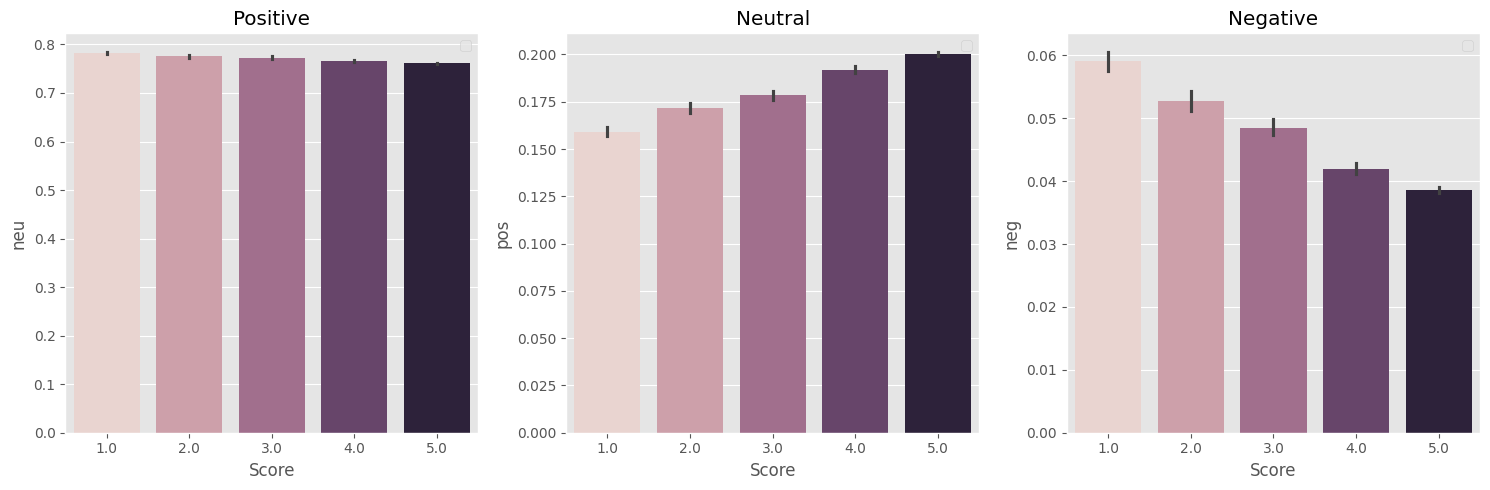

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vader_score_df, x='Score', y='pos', hue='Score', ax=axs[1])
sns.barplot(data=vader_score_df, x='Score', y='neu', hue='Score', ax=axs[0])
sns.barplot(data=vader_score_df, x='Score', y='neg', hue='Score', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

axs[0].legend('')
axs[1].legend('')
axs[2].legend('')

plt.tight_layout()
plt.show()

### #) Roberta Pretrained Model

In [98]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [99]:
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [101]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [107]:
print(output[0])
print(output[0][0])
print(output[0][0].detach())
print(output[0][0].detach().numpy())

tensor([[ 3.1436, -0.7107, -2.6559]], grad_fn=<AddmmBackward0>)
tensor([ 3.1436, -0.7107, -2.6559], grad_fn=<SelectBackward0>)
tensor([ 3.1436, -0.7107, -2.6559])
[ 3.1436293  -0.71066886 -2.6558964 ]


In [108]:
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.97635514, 0.02068747, 0.00295737], dtype=float32)

In [109]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.02068747,
 'roberta_pos': 0.0029573706}

In [110]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }

  return scores_dict

In [120]:
results = {}

for index, row in tqdm(df.head(500).iterrows(), total=len(df.head(500))):
  try:
      text = row['Text']
      id = row['Id']


      vader_result = sia.polarity_scores(text)
      vader_result_rename = {}
      for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value


      roberta_result = polarity_scores_roberta(text)

      total_result = {**vader_result_rename, **roberta_result}
      results[id] = total_result

  except RuntimeError:
      pass

  0%|          | 0/500 [00:00<?, ?it/s]

In [121]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### #) Compare Scores between models

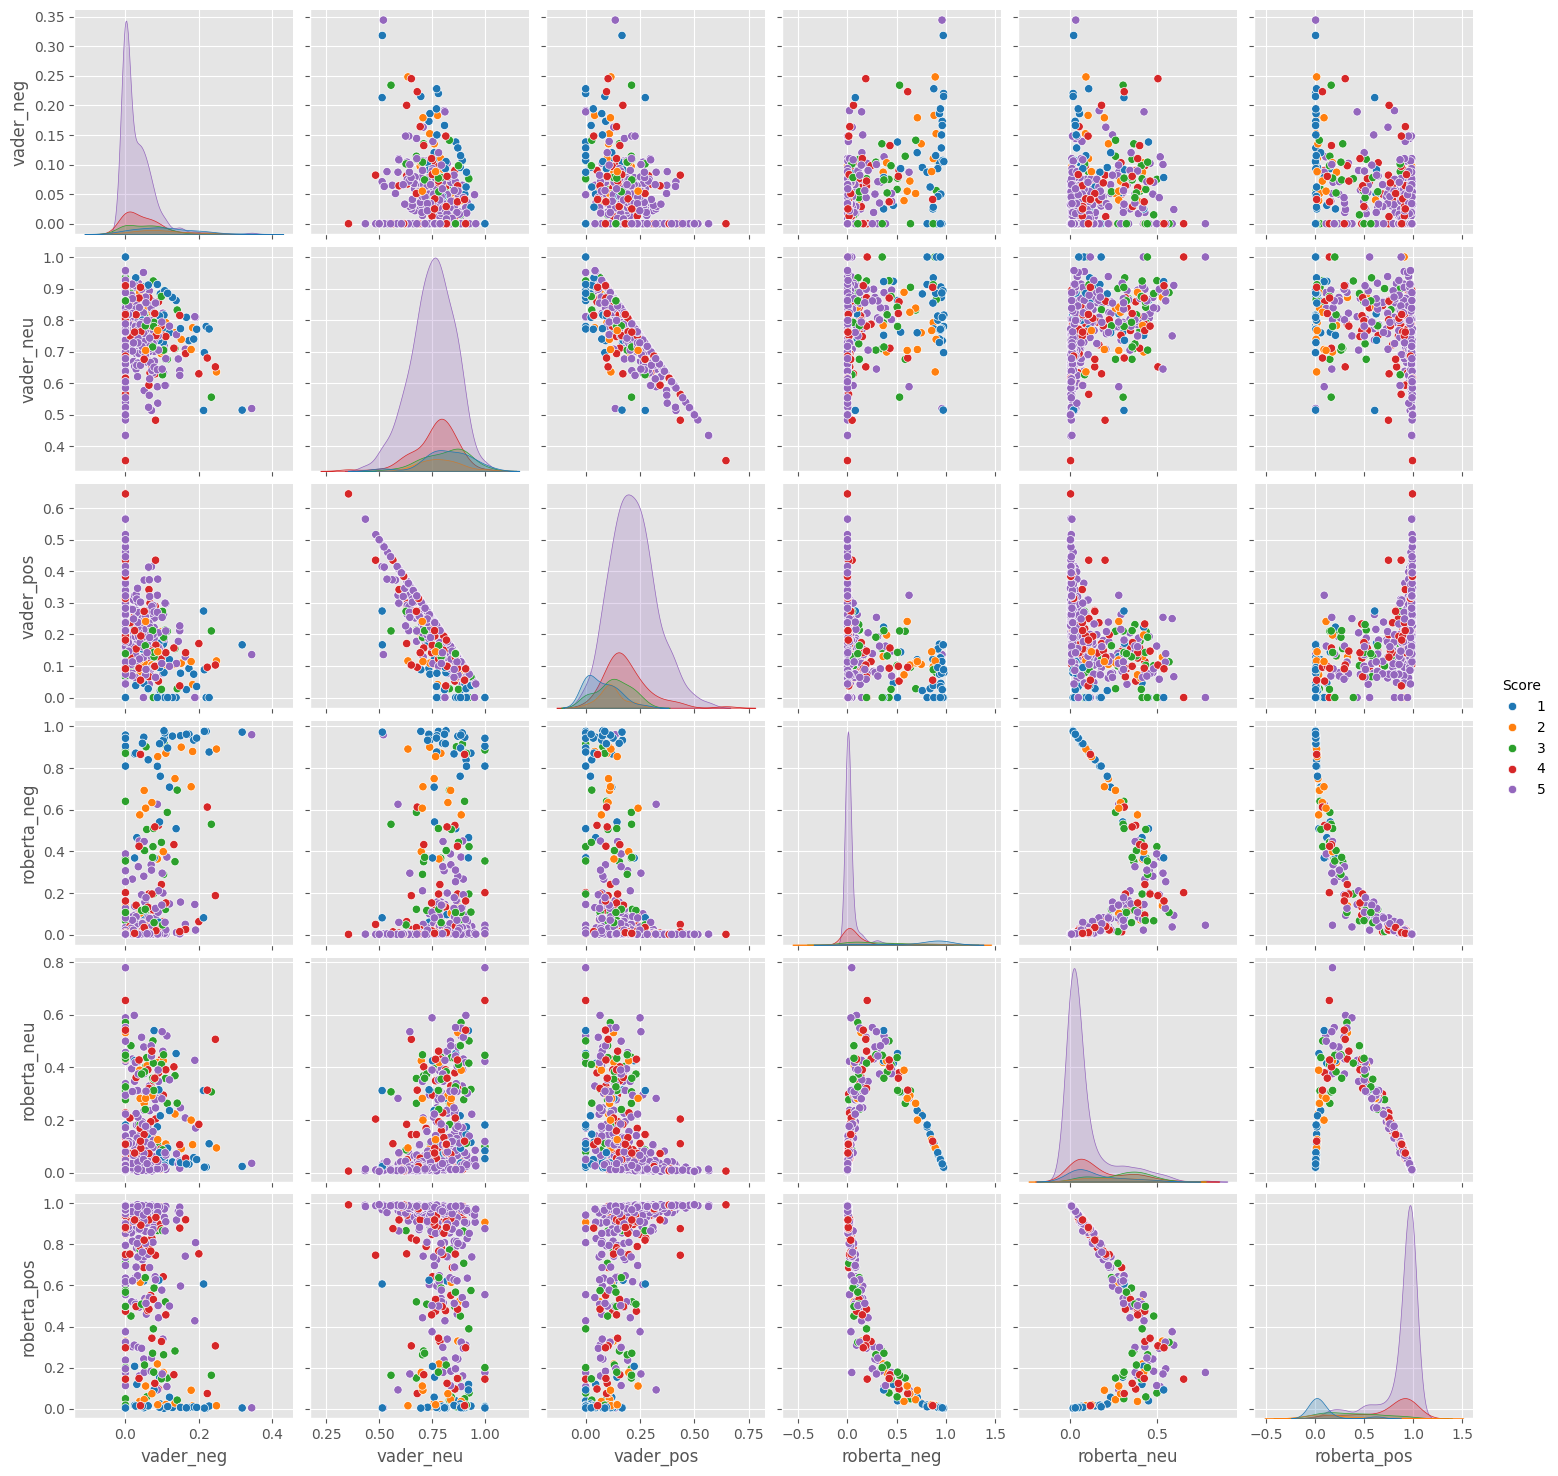

In [123]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue='Score', palette='tab10')
plt.show()

In [125]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [126]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'